## Count double positive nuclei

Work done for [this image.sc question](https://forum.image.sc/t/count-single-and-double-positive-nuclei-with-python/112787)

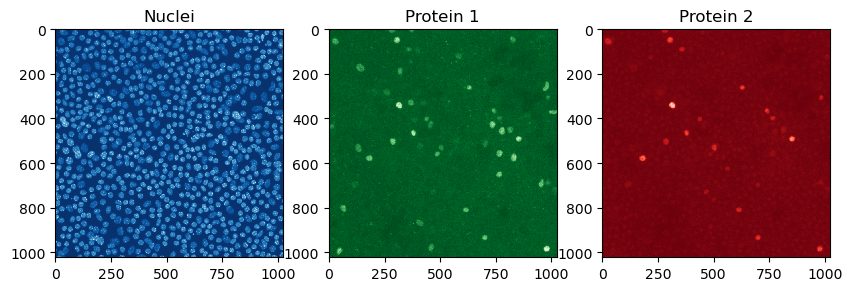

In [1]:
from skimage.io import imread
from plt_helper import imshow_multi2d
import os

parent_path = r"D:\images\tnia-python-images\imagesc\2025_05_23_double_positive"

nuclei = imread(os.path.join(parent_path, "nuclei.tif"))
protein1 = imread(os.path.join(parent_path, "protein1.tif"))
protein2 = imread(os.path.join(parent_path, "protein2.tif"))

fig = imshow_multi2d([nuclei, protein1, protein2],
                     ["Nuclei", "Protein 1", "Protein 2"],
                     1, 3, colormaps=['Blues_r', 'Greens_r', 'Reds_r'])



In [8]:
import napari
viewer = napari.Viewer()
viewer.add_image(nuclei, name='Nuclei', colormap='blue', opacity=0.5)
viewer.add_image(protein1, name='Protein 1', colormap='green', opacity=0.5)
viewer.add_image(protein2, name='Protein 2', colormap='red', opacity=0.5)

<Image layer 'Protein 2' at 0x25d5bf13950>

In [3]:
import cellpose
from cellpose import models
major_number = cellpose.version.split('.')[0]
print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

if major_number == '3':
    model = models.Cellpose(gpu=True, model_type='cyto3')
elif major_number == '4':
    model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


Cellpose version: 4.0.1 (major number: 4)


In [4]:
Nuclei_segmented = model.eval(nuclei, diameter=None)[0]
viewer.add_labels(Nuclei_segmented, name='Nuclei Segmented')

<Labels layer 'Nuclei Segmented' at 0x25d5da5c490>

In [5]:
protein1_segmented = model.eval(protein1, diameter=None)[0]
viewer.add_labels(protein1_segmented, name='Protein 1 Segmented')
protein2_segmented = model.eval(protein2, diameter=None)[0]
viewer.add_labels(protein2_segmented, name='Protein 2 Segmented')

<Labels layer 'Protein 2 Segmented' at 0x25d52d29550>

In [16]:
import pandas as pd
from skimage import measure
import numpy as np

# Code generated partly by ChatGPT

# measure intensity of protein1 in the masks
props1 = measure.regionprops_table(
    Nuclei_segmented,
    intensity_image=protein1,
    properties=('label', 'area', 'mean_intensity')
)

# measure intensity of protein2 in the masks
props2 = measure.regionprops_table(
    Nuclei_segmented,
    intensity_image=protein2,
    properties=('label', 'mean_intensity')
)

# Convert to DataFrames
df1 = pd.DataFrame(props1)
df2 = pd.DataFrame(props2)
df = df1.merge(df2, on='label', suffixes=('_protein1', '_protein2'))

print(df.head())

# calculate threshold1 and threshold2 based on intensity percentiles in the image
print(df.mean_intensity_protein1.max())
threshold1 = np.percentile(protein1, 95)
print(df.mean_intensity_protein2.max())
threshold2 = np.percentile(protein2, 93)

# Keep only masks with intensity above the thresholds (or both threshold in the third case)  
filtered_protein1 = df[(df.mean_intensity_protein1 > threshold1) &
                       ~(df.mean_intensity_protein2 > threshold2)]
filtered_protein2 = df[(df.mean_intensity_protein2 > threshold2) &
                       ~(df.mean_intensity_protein1 > threshold1)]
filtered_both = df[
    (df.mean_intensity_protein1 > threshold1) &
    (df.mean_intensity_protein2 > threshold2)
]

keep_protein1_labels = filtered_protein1['label'].to_numpy()
keep_protein2_labels = filtered_protein2['label'].to_numpy()
keep_both_labels = filtered_both['label'].to_numpy()

protein1_labels = np.isin(Nuclei_segmented, keep_protein1_labels) * Nuclei_segmented
protein2_labels = np.isin(Nuclei_segmented, keep_protein2_labels) * Nuclei_segmented
both_labels = np.isin(Nuclei_segmented, keep_both_labels) * Nuclei_segmented

viewer.add_labels(protein1_labels, name='Protein 1 Filtered')
viewer.add_labels(protein2_labels, name='Protein 2 Filtered')
viewer.add_labels(both_labels, name='Both Filtered')

   label   area  mean_intensity_protein1  mean_intensity_protein2
0      1  303.0                71.141914                68.003300
1      2  165.0                77.169697                69.272727
2      3  540.0                73.764815                68.555556
3      4  557.0               129.369838               149.806104
4      5  214.0                75.093458                73.415888
241.0611413043478
379.70244565217394


<Labels layer 'Both Filtered [1]' at 0x25d5344f850>

In [14]:
type(protein1_labels)
protein1_labels.shape

(49,)

<Axes: ylabel='Frequency'>

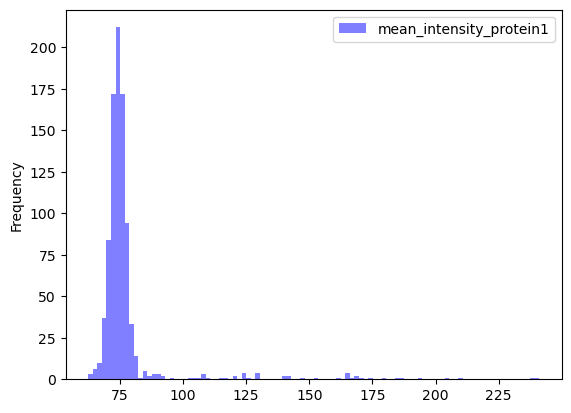

In [9]:
df.plot.hist(y='mean_intensity_protein1', bins=100, alpha=0.5, color='blue')

<Axes: ylabel='Frequency'>

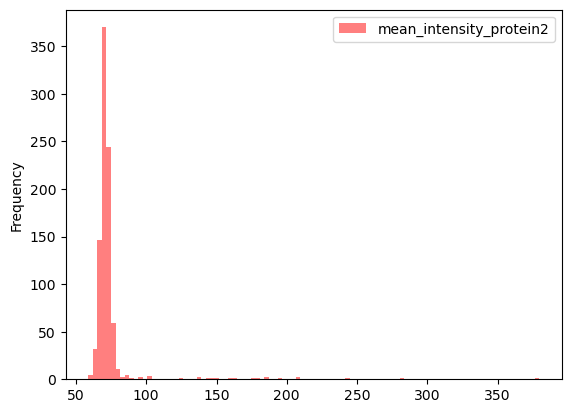

In [10]:
df.plot.hist(y='mean_intensity_protein2', bins=100, alpha=0.5, color='red')

In [ ]:


'''
# Step 3: Keep only masks with intensity above threshold t
t = 0.5  # your intensity threshold
filtered_df = df[df['mean_intensity'] > t]

# Optional: Get mask with only high-intensity regions
keep_labels = filtered_df['label'].to_numpy()
filtered_mask = np.isin(labeled_mask, keep_labels) * labeled_mask
'''